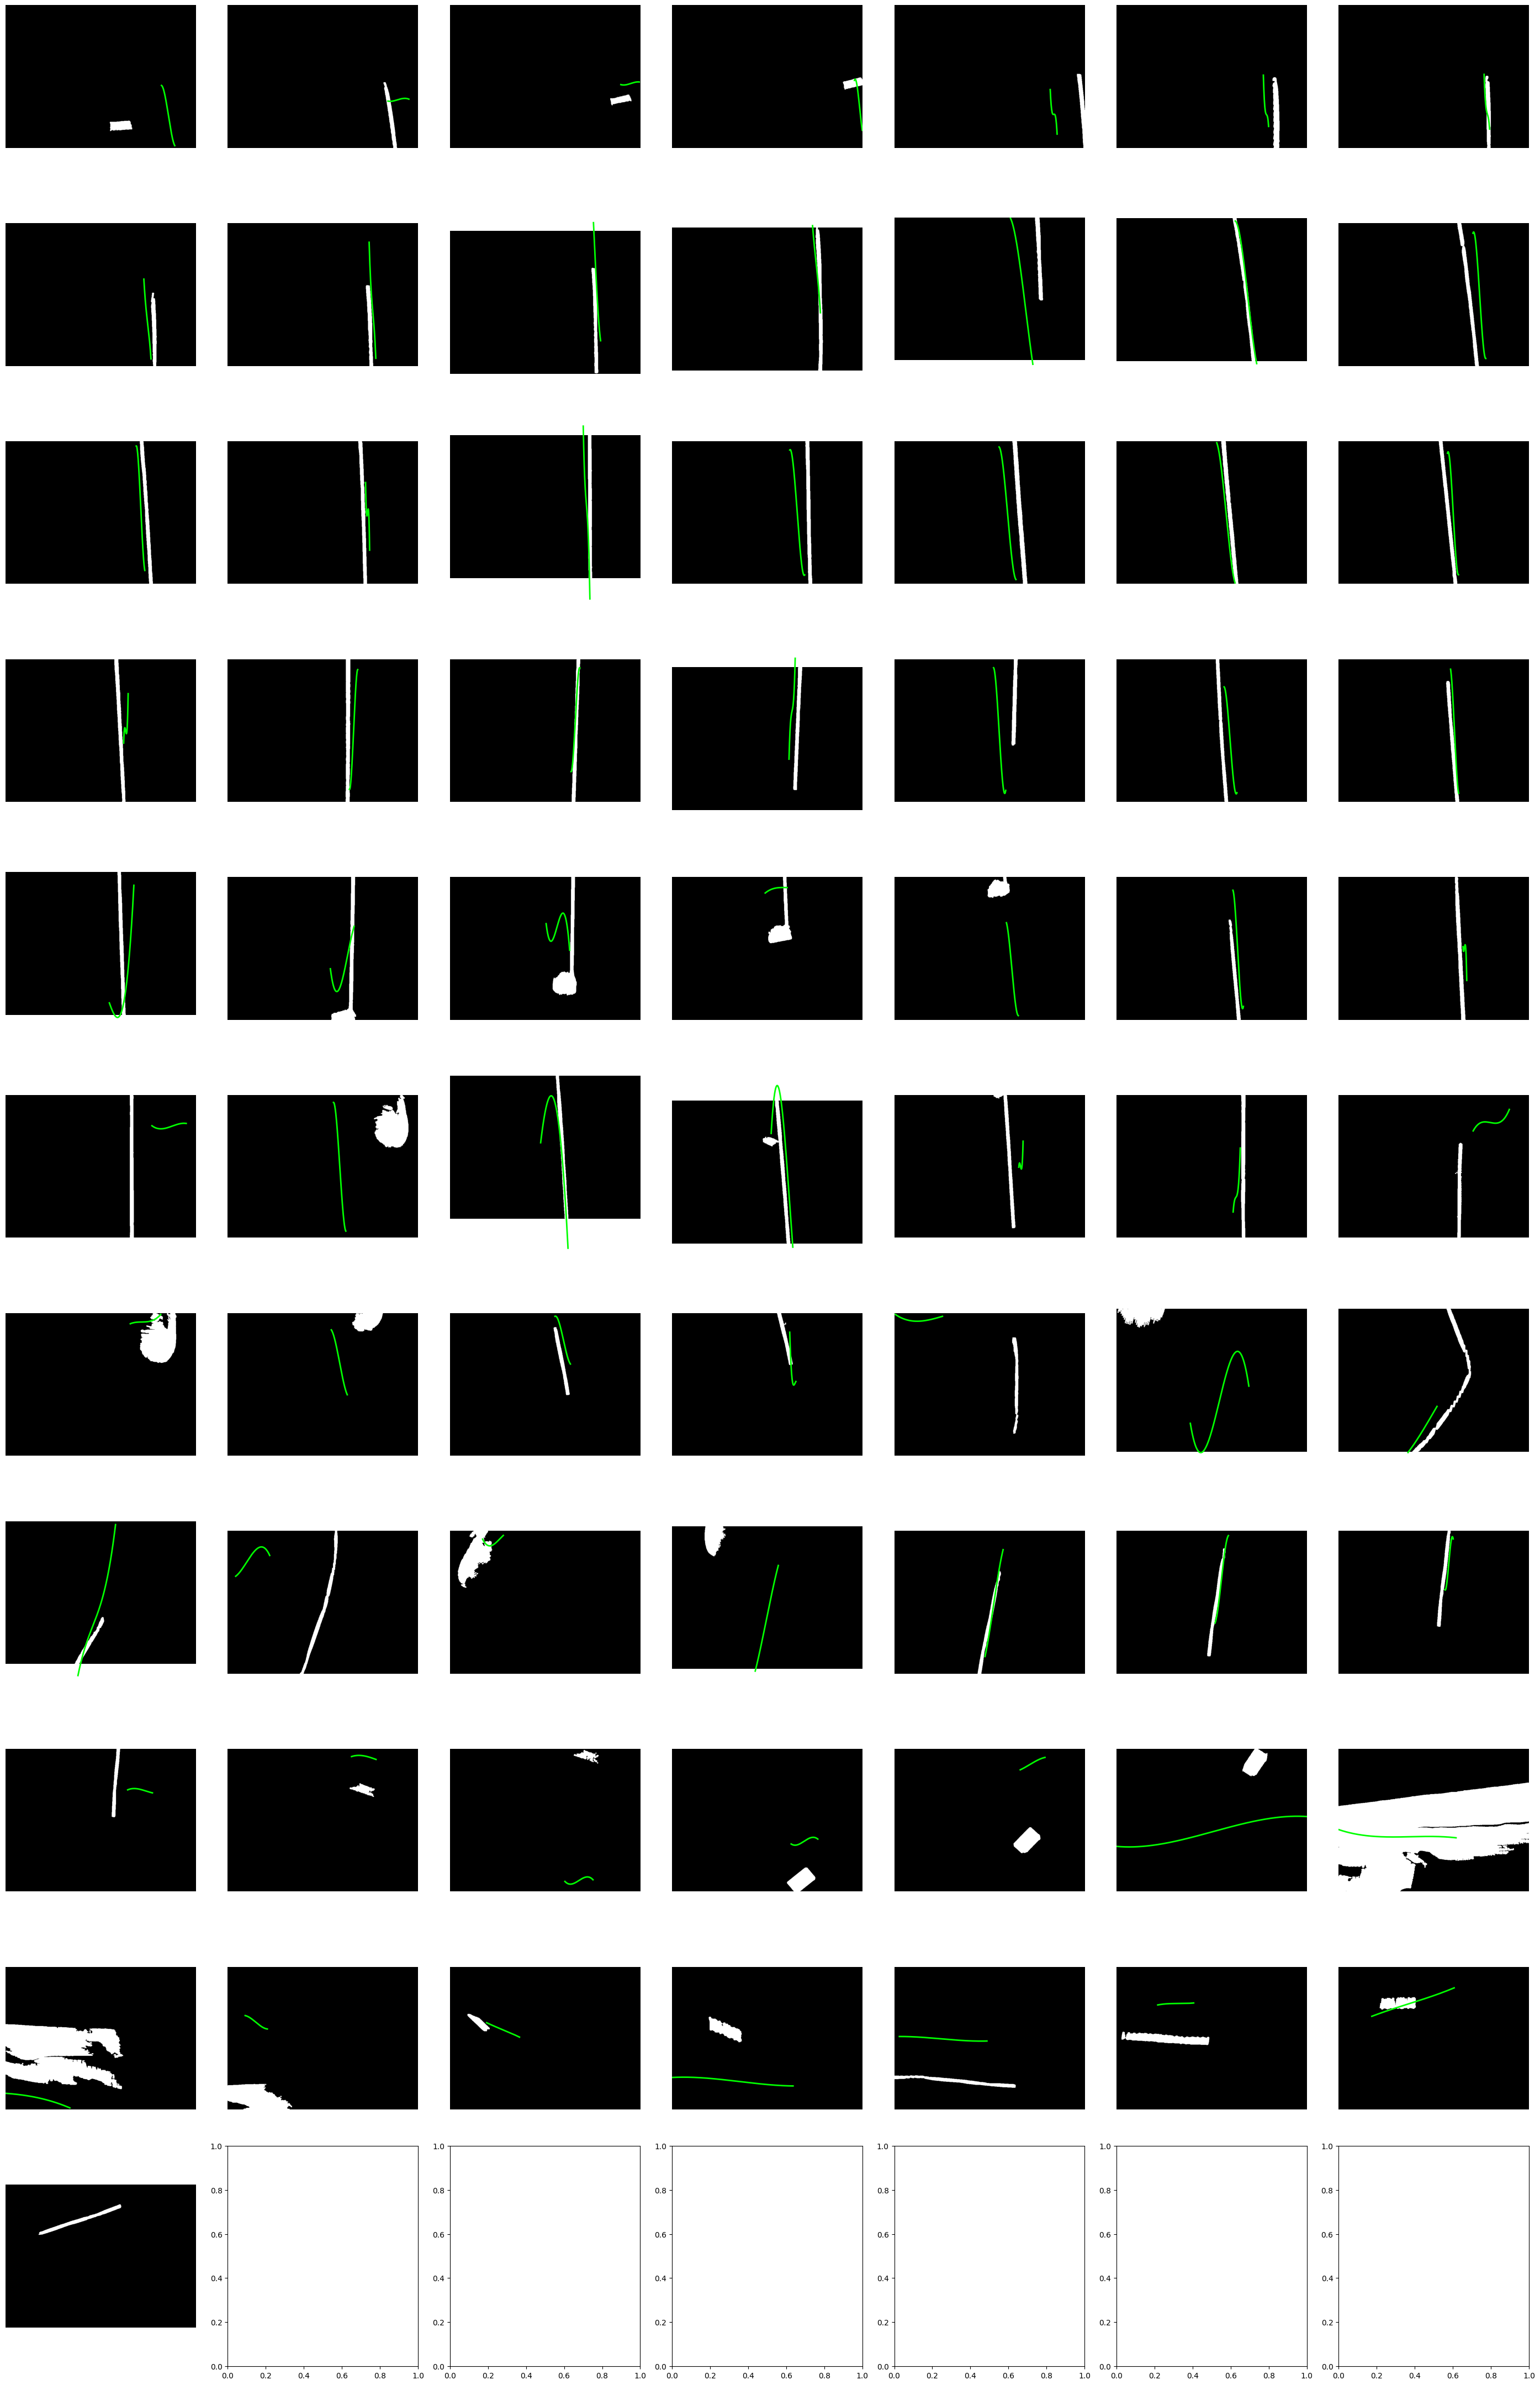

In [3]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from matplotlib.patches import Rectangle
from scipy.stats import linregress
import matplotlib.patches as patches
from matplotlib.lines import Line2D

frames = glob.glob("frames/frame_*.png")
frames.sort()  # This works because frame numbers are zero-padded
frames = [cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in frames]

fig,axes = plt.subplots(11,7,figsize=(28,44))
axes = axes.flatten()  # turn 2D array into 1D list of axes

def calculate_regression(points):
    # convert points to float
    points = points.astype(float)
    xs = points[:, 1]  # x coordinates
    ys = points[:, 0]  # y coordinates

    # Vertical line case
    x_var = np.var(xs)
    y_var = np.var(ys)

    if x_var < 1e-2 * y_var:
        x = np.mean(xs)
        return ('vertical', x)

    # Regular linear regression
    x_mean = np.mean(xs)
    y_mean = np.mean(ys)
    xy_mean = np.mean(xs * ys)
    x_squared_mean = np.mean(xs ** 2)

    m = (x_mean * y_mean - xy_mean) / (x_mean ** 2 - x_squared_mean)
    b = y_mean - m * x_mean

    return (m, b)

def find_inliers(m_or_type, b_or_x, shape):
    x1, y1, x2, y2 = None, None, None, None # TODO
    height, width = shape

    if m_or_type == 'vertical':
        x = b_or_x
        if 0 <= x <= width:
            return x, 0, x, height
        else:
            return None

    m, b = m_or_type, b_or_x
    points = []

    y_left = b
    if 0 <= y_left <= height:
        points.append((0, y_left))
    y_right = m * width + b
    if 0 <= y_right <= height:
        points.append((width, y_right))
    x_top = -b / m if m != 0 else None
    if x_top is not None and 0 <= x_top <= width:
        points.append((x_top, 0))
    x_bottom = (height - b) / m if m != 0 else None
    if x_bottom is not None and 0 <= x_bottom <= width:
        points.append((x_bottom, height))

    if len(points) < 2:
        return None

    (x1,y1), (x2,y2) = points[:2]
    
    return x1, y1, x2, y2

def fit_polynomial_curve(points, degree=3):
    """Fit a polynomial curve to contour points."""
    xs = points[:, 1]
    ys = points[:, 0]
    
    # Sort by x for smoother plotting
    sorted_indices = np.argsort(xs)
    xs = xs[sorted_indices]
    ys = ys[sorted_indices]
    
    coeffs = np.polyfit(xs, ys, degree)
    poly = np.poly1d(coeffs)
    return poly, xs



for i, image in enumerate(frames):
    #dilate
    imgray = image.copy()
    kernel = np.ones((4,4),np.uint8);
    imgray = cv2.dilate(imgray,kernel,iterations = 1)

    #binary threshold and find contours
    ret, thresh = cv2.threshold(imgray, 230, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    long_contours = [c for c in contours if cv2.contourArea(c) > 200]  # adjust threshold as needed
    image_with_box = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2BGR)

    if long_contours:
        # Optional: pick the largest among valid long rectangles
        best_contour = max(long_contours, key=cv2.contourArea)

        # Create a blank mask and draw only the selected contour(s)
        mask = np.zeros_like(thresh)
        cv2.drawContours(mask, [best_contour], -1, 255, thickness=cv2.FILLED)

        #draw bounding box on image
        x, y, w, h = cv2.boundingRect(best_contour)
        cv2.rectangle(image_with_box, (x, y), (x + w, y + h), (0, 0, 255), 2)

        # Update threshold to only include selected contour
        thresh = mask

        #check if there's enough rope
        white_pixel_count = np.count_nonzero(thresh)
        #print(white_pixel_count)
        pixel_threshold = 0.0 * thresh.size  # e.g., 1% of the image
        #print("pixel threshold",pixel_threshold)

        if white_pixel_count > pixel_threshold:
            #add regression line
            points = np.argwhere(thresh)
            if len(points) >= 5:  # Ensure enough points for fitting
                poly, xs = fit_polynomial_curve(points, degree=3)
                ys = poly(xs)
                ax.plot(xs, ys, color='lime', linewidth=2)

    else:
        # If no valid long contour found, make thresh blank so we skip regression
        thresh = np.zeros_like(thresh)
    
    ax = axes[i]
    ax.imshow(image_with_box, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()